In [1]:
%pushd cs231n/datasets
!   bash get_datasets.sh
%popd

/Users/jleem/Gaebal/@AI/cs231n/assignments/assignment1/cs231n/datasets
/Users/jleem/Gaebal/@AI/cs231n/assignments/assignment1
popd -> ~/Gaebal/@AI/cs231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [16]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.360846
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 


$
\begin{gather}
\text{(scores)} = \mathbf{X}\mathbf{W} = \mathbf{X}\mathbf{0} = \mathbf{0}
\\
\text{Cross Entropy (}\L_i\text{)} = -\log{\frac{e^0}{\sum^{10}_{i=1}{e^0}} = -\log(0.1)
\end{gather}
$

In [25]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.252532 analytic: 3.252532, relative error: 5.043520e-09
numerical: -3.310826 analytic: -3.310826, relative error: 3.405246e-10
numerical: -1.520439 analytic: -1.520439, relative error: 8.878258e-09
numerical: -1.126350 analytic: -1.126350, relative error: 2.665551e-09
numerical: -0.738831 analytic: -0.738832, relative error: 2.573269e-08
numerical: 1.198649 analytic: 1.198649, relative error: 1.351985e-08
numerical: 0.192099 analytic: 0.192099, relative error: 2.529278e-07
numerical: 0.895681 analytic: 0.895681, relative error: 5.560768e-08
numerical: -0.540189 analytic: -0.540189, relative error: 3.591684e-09
numerical: -2.868438 analytic: -2.868438, relative error: 1.322278e-08
numerical: 1.199052 analytic: 1.199051, relative error: 5.227470e-08
numerical: 1.373048 analytic: 1.373047, relative error: 4.454949e-08
numerical: -1.103573 analytic: -1.103573, relative error: 1.306530e-08
numerical: -1.191635 analytic: -1.191635, relative error: 2.508125e-08
numerical: -1.5210

In [37]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.360846e+00 computed in 0.041943s
vectorized loss: 2.360846e+00 computed in 0.027128s
Loss difference: 0.000000
Gradient difference: 0.000000


In [55]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-6, 5e-4]
regularization_strengths = [2.5e2, 5e6]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import itertools

num_iters = 500
batch_size = 200

learning_rates_it = np.logspace(*np.log10(learning_rates), 10)
regularization_strengths_it = np.logspace(*np.log10(regularization_strengths), 10)
params_it = itertools.product(learning_rates_it, regularization_strengths_it)

best_softmax = None
best_accuracy = -1

for params_tuple in params_it:
    (learning_rate, regularization_strength) = params_tuple
    softmax = Softmax()
    
    print('Training with learning_rate=%e, regularization_strength=%e' % (learning_rate, regularization_strength))
    softmax.train(
        X = X_train,
        y = y_train,
        learning_rate=learning_rate,
        reg=regularization_strength,
        num_iters=num_iters,
        batch_size=batch_size,
    )
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[params_tuple] = (train_accuracy, val_accuracy)
    print('\t👉 Train accuracy: %.4f, Validation accuracy: %.4f' % (train_accuracy, val_accuracy))
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
   

Training with learning_rate=1.000000e-06, regularization_strength=2.500000e+02
	👉 Train accuracy: 0.2968, Validation accuracy: 0.2960
Training with learning_rate=1.000000e-06, regularization_strength=7.513326e+02
	👉 Train accuracy: 0.2987, Validation accuracy: 0.3070
Training with learning_rate=1.000000e-06, regularization_strength=2.258003e+03
	👉 Train accuracy: 0.2921, Validation accuracy: 0.2710
Training with learning_rate=1.000000e-06, regularization_strength=6.786044e+03
	👉 Train accuracy: 0.2915, Validation accuracy: 0.3090
Training with learning_rate=1.000000e-06, regularization_strength=2.039430e+04
	👉 Train accuracy: 0.2939, Validation accuracy: 0.2880
Training with learning_rate=1.000000e-06, regularization_strength=6.129162e+04
	👉 Train accuracy: 0.2967, Validation accuracy: 0.2960
Training with learning_rate=1.000000e-06, regularization_strength=1.842016e+05
	👉 Train accuracy: 0.3028, Validation accuracy: 0.3120
Training with learning_rate=1.000000e-06, regularization_stren

/Users/jleem/Gaebal/@AI/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:115: RuntimeWarning: overflow encountered in exp
  scores_exp = np.exp(scores)
/Users/jleem/Gaebal/@AI/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:132: RuntimeWarning: invalid value encountered in true_divide
  d_scores += d_LSE[:, np.newaxis] * (scores_exp / scores_exp_sum[:, np.newaxis])


	👉 Train accuracy: 0.1003, Validation accuracy: 0.0870
Training with learning_rate=2.506597e-04, regularization_strength=7.513326e+02
	👉 Train accuracy: 0.1003, Validation accuracy: 0.0870
Training with learning_rate=2.506597e-04, regularization_strength=2.258003e+03
	👉 Train accuracy: 0.1003, Validation accuracy: 0.0870
Training with learning_rate=2.506597e-04, regularization_strength=6.786044e+03
	👉 Train accuracy: 0.1003, Validation accuracy: 0.0870
Training with learning_rate=2.506597e-04, regularization_strength=2.039430e+04
	👉 Train accuracy: 0.1003, Validation accuracy: 0.0870
Training with learning_rate=2.506597e-04, regularization_strength=6.129162e+04
	👉 Train accuracy: 0.1003, Validation accuracy: 0.0870
Training with learning_rate=2.506597e-04, regularization_strength=1.842016e+05
	👉 Train accuracy: 0.1003, Validation accuracy: 0.0870
Training with learning_rate=2.506597e-04, regularization_strength=5.535866e+05
	👉 Train accuracy: 0.1003, Validation accuracy: 0.0870
Trainin

In [56]:
best_val = best_accuracy 
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-06 reg 2.500000e+02 train accuracy: 0.296837 val accuracy: 0.296000
lr 1.000000e-06 reg 7.513326e+02 train accuracy: 0.298653 val accuracy: 0.307000
lr 1.000000e-06 reg 2.258003e+03 train accuracy: 0.292122 val accuracy: 0.271000
lr 1.000000e-06 reg 6.786044e+03 train accuracy: 0.291510 val accuracy: 0.309000
lr 1.000000e-06 reg 2.039430e+04 train accuracy: 0.293898 val accuracy: 0.288000
lr 1.000000e-06 reg 6.129162e+04 train accuracy: 0.296673 val accuracy: 0.296000
lr 1.000000e-06 reg 1.842016e+05 train accuracy: 0.302837 val accuracy: 0.312000
lr 1.000000e-06 reg 5.535866e+05 train accuracy: 0.298673 val accuracy: 0.296000
lr 1.000000e-06 reg 1.663711e+06 train accuracy: 0.299633 val accuracy: 0.303000
lr 1.000000e-06 reg 5.000000e+06 train accuracy: 0.302061 val accuracy: 0.302000
lr 1.994737e-06 reg 2.500000e+02 train accuracy: 0.328224 val accuracy: 0.315000
lr 1.994737e-06 reg 7.513326e+02 train accuracy: 0.330571 val accuracy: 0.334000
lr 1.994737e-06 reg 2.258003

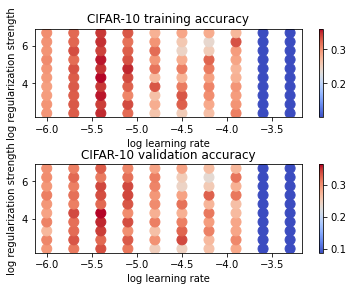

In [58]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# set background color to white
plt.rcParams['figure.facecolor'] = 'white'

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results]  # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [59]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.333000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$

True.
In SVM, newly added data point will not change the loss if it is correctly classified and its margin is greater than 1.
In Softmax, newly added data point will always change the loss, because it will change the probabilities of all other classes.

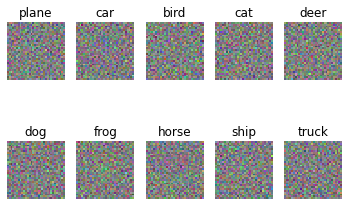

In [60]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])